# Classification

Classification is the task of predicting a label, category, class, or discrete variable given some input features. The key difference from other ML tasks, such as regression, is that the output label has a finite set of possible values (e.g., three classes).

Here are a few of the multitude of ways classification can be used in the real world.

**Predicting credit risk**

A financing company might look at a number of variables before offering a loan to a company or individual. Whether or not to offer the loan is a binary classification problem.

**News classification**

An algorithm might be trained to predict the topic of a news article (sports, politics, business, etc.).

**Classifying human activity**

By collecting data from sensors such as a phone accelerometer or smart watch, you can predict the person’s activity. The output will be one of a finite set of classes (e.g., walking, sleeping, standing, or running).

## Types of Classification

Before we continue, let’s review several different types of classification.

### Binary Classification

The simplest example of classification is binary classification, where there are only two labels you can predict. One example is fraud analytics, where a given transaction can be classified as fraudulent or not; or email spam, where a given email can be classified as spam or not spam.

### Multiclass Classification

Beyond binary classification lies multiclass classification, where one label is chosen from more than two distinct possible labels. A typical example is Facebook predicting the people in a given photo or a meterologist predicting the weather (rainy, sunny, cloudy, etc.). Note how there is always a finite set of classes to predict; it’s never unbounded. This is also called multinomial classification.

### Multilabel Classification

Finally, there is multilabel classification, where a given input can produce multiple labels. For example, you might want to predict a book’s genre based on the text of the book itself. While this could be multiclass, it’s probably better suited for multilabel because a book may fall into multiple genres. Another example of multilabel classification is identifying the number of objects that appear in an image. Note that in this example, the number of output predictions is not necessarily fixed, and could vary from image to image.

## Classification Models in MLlib

Spark has several models available for performing binary and multiclass classification out of the box. The following models are available for classification in Spark:

* [Logistic regression](http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression)
* [Decision trees](http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)
* [Random forests](http://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier)
* [Gradient-boosted trees](http://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier)
* [Multilayer perceptron classifier](http://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier)

For a full list of all available classifiers in Spark checkout the [documentation](http://spark.apache.org/docs/latest/ml-classification-regression.html#classification).

Spark does not support making multilabel predictions natively. In order to train a multilabel model, you must train one model per label and combine them manually. Once manually constructed, there are built-in tools that support measuring these kinds of models.

This notebook will cover the basics of each of these models by providing:

* A simple explanation of the model and the intuition behind it
* Model hyperparameters (the different ways we can initialize the model)
* Training parameters (parameters that affect how the model is trained)
* Prediction parameters (parameters that affect how predictions are made)

You can set the hyperparameters and training parameters in a `ParamGrid`.

### Model Scalability

Model scalability is an important consideration when choosing your model. In general, Spark has great support for training large-scale machine learning models (note, these are large scale; on single-node workloads there are a number of other tools that also perform well). Table below is a simple model scalability scorecard to use to find the best model for your particular task (if scalability is your core consideration). The actual scalability will depend on your configuration, machine size, and other specifics but should make for a good heuristic.

Model scalability reference

|Model|	Features count|	Training examples|	Output classes|
|--|--|--|--|
|Logistic regression|1 to 10 million|No limit|Features x Classes < 10 million|
|Decision trees|1,000s|No limit|Features x Classes < 10,000s|
|Random forest|10,000s|No limit|Features x Classes < 100,000s|
|Gradient-boosted trees|1,000s|No limit|Features x Classes < 10,000s|

We can see that nearly all these models scale to large collections of input data and there is ongoing work to scale them even further. The reason no limit is in place for the number of training examples is because these are trained using methods like stochastic gradient descent. These methods are optimized specifically for working with massive datasets and to remove any constraints that might exist on the number of training examples you would hope to learn on.

## Logistic Regression

Logistic regression is one of the most popular methods of classification. It is a linear method that combines each of the individual inputs (or features) with specific weights (these weights are generated during the training process) that are then combined to get a probability of belonging to a particular class. These weights are helpful because they are good representations of feature importance; if you have a large weight, you can assume that variations in that feature have a significant effect on the outcome (assuming you performed normalization). A smaller weight means the feature is less likely to be important.

Consider the following example: The *Default* Dataset

<img src="https://github.com/soltaniehha/Big-Data-Analytics-for-Business/blob/master/figs/11-01-the-default-dataset.png?raw=true" width="800" align="center"/>

<div style="text-align: center"> The Default data set. Left: The annual incomes and monthly credit card balances of a number of individuals. The individuals who defaulted on their credit card payments are shown in orange, and those who did not are shown in blue. Center: Boxplots of balance as a function of default status. Right: Boxplots of income as a function of default status. </div>

*<div style="text-align: right"> From [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, et al </div>*

Considering this data where the response "default" falls into a "Yes" or "No" category, let's find a model that can predict the probability of default by using the "Balance" on the credit card. Rather than modeling this response Y
directly, logistic regression models the probability that Y belongs to a particular category.

The probability of default given balance can be written as:
> **Pr(**default = Yes|balance**)**

The values of Pr(default = Yes|balance), which we abbreviate p(balance), will range between 0 and 1. Then for any given value of balance, a prediction can be made for default. For example, one might predict default = Yes for any individual for whom p(balance) > 0.5. Alternatively, if a company wishes to be conservative in predicting individuals who are at risk for default, then they may choose to use a lower threshold, such as p(balance) > 0.1.


<img src="https://github.com/soltaniehha/Big-Data-Analytics-for-Business/blob/master/figs/11-01-Classification-lr.png?raw=true" width="800" align="center"/>

<div style="text-align: center"> Classification using the Default data. Left: Estimated probability of default using linear regression. Some estimated probabilities are negative! The orange ticks indicate the 0/1 values coded for default(No or Yes). Right: Predicted probabilities of default using logistic regression. All probabilities lie between 0 and 1.
 </div>

*<div style="text-align: right"> From [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, et al </div>*

### The Logistic Model

How should we model the relationship between $p(X) = Pr(Y = 1|X)$ and $X$? (For convenience we are using the generic 0/1 coding for the response). One approach would be using a linear regression model to represent these probabilities:

> $p(X) = \beta_0 + \beta_1 X$

If we use this approach to predict default=Yes using balance, then we obtain the model shown in the left-hand panel of figure above. Here we see the problem with this approach: for balances close to zero we predict a negative probability of default; if we were to predict for very large balances, we would get values bigger than 1. These predictions are not sensible, since of course the true probability of default, regardless of credit card balance, must fall between 0 and 1.

To avoid this problem, we must model $p(X)$ using a function that gives outputs between 0 and 1 for all values of $X$. Many functions meet this description. In logistic regression, we use the logistic function:

> $p(X) = \dfrac{e ^ {\beta_0 + \beta_1 X }}{1 + e ^ {\beta_0 + \beta_1 X }}$

To fit the model above, we use a method called `maximum likelihood`. The right-hand panel of figure above illustrates the fit of the logistic regression model to the Default data. Notice that for low balances we now predict the probability of default as close to, but never below, zero. Likewise, for high balances we predict a default probability close to, but never above, one. The logistic function will always produce an S-shaped curve of this form, and so regardless of the value of X, we will obtain a sensible prediction. We also see that the logistic model is
better able to capture the range of probabilities than is the linear regression model in the left-hand plot. 

After a bit of manipulation of the logistic function, we find that:

> $\dfrac{p(X)}{1-p(X)} = e ^ {\beta_0 + \beta_1 X }$

The quantity $p(X)/[1−p(X)]$ is called the odds, and can take on any value between $0$ and $\infty$. Values of the odds close to $0$ and $\infty$ indicate very low and very high probabilities of default, respectively. 

For example, Let’s say that the probability of default is $0.2$ (or $1$ in $5$ people), this will give an odds of default equal to $1$ to $4$. This means that the odds of someone defaulting is $25\%$ of not defaulting. Since $p(X) = 0.2$ implies an odds of $\dfrac{0.2}{1-0.2} = 1/4$. 

Likewise on average $9$ out of every $10$ people with an odds of $9$ will default, since $p(X) = 0.9$ implies an odds of $\dfrac{0.9}{1-0.9} = 9$.

Odds are traditionally used instead of probabilities in horse-racing, since they relate more naturally to the correct betting strategy.

By taking the logarithm of both sides of the equation above, we arrive at

> $log(\dfrac{p(X)}{1-p(X)}) = \beta_0 + \beta_1 X$


The left-hand side is called the *log-odds* or *logit*. We see that the logistic regression mdoel (defined above) has a logit that is linear in $X$.

The table below shows estimated coefficients of the logistic regression model that predicts the probability of "default" using "balance":

| - |Coefficient| Std. error| Z-statistic| P-value|
|--|--|--|--|--|
|Intercept| −10.6513| 0.3612| −29.5| <0.0001|
|balance |0.0055 |0.0002 |24.9 |<0.0001|

We can measure the accuracy of the coefficient estimates by computing their standard errors. The z-statistic in table above plays the same role as the t-statistic in the linear regression output. A large (absolute) value of the z-statistic indicates evidence against the null hypothesis $H0 : β1 = 0$. This null hypothesis implies that $p(X) = \dfrac{e ^ {\beta_0 }}{1 + e ^ {\beta_0 }}$. In other words, that the probability of default does not depend on balance. Since the p-value associated with balance in the table is tiny, we can reject $H0$. In other words, we conclude that there is indeed an association between balance and probability of default. 

The estimated intercept in the table is typically not of interest; its main purpose is to adjust the average fitted
probabilities to the proportion of ones in the data.

### Model Hyperparameters

Model hyperparameters are configurations that determine the basic structure of the model itself. The following hyperparameters are available for logistic regression:

**`family`** (default: auto)

Can be multinomial (two or more distinct labels; multiclass classification) or binary (only two distinct labels; binary classification).

**`elasticNetParam`** (default: 0.0)

A floating-point value from 0 to 1. This parameter specifies the mix of L1 and L2 regularization according to elastic net regularization (which is a linear combination of the two). Your choice of L1 or L2 depends a lot on your particular use case but the intuition is as follows: L1 regularization (a value of 1) will create sparsity in the model because certain feature weights will become zero (that are of little consequence to the output). For this reason, it can be used as a simple feature-selection method. On the other hand, L2 regularization (a value of 0) does not create sparsity because the corresponding weights for particular features will only be driven toward zero, but will never completely reach zero. ElasticNet gives us the best of both worlds—we can choose a value between 0 and 1 to specify a mix of L1 and L2 regularization. For the most part, you should be tuning this by testing different values.

Note: Regularization is a technique to discourage the complexity of the model. It does this by penalizing the loss function. This helps to solve the overfitting problem. Here is a brief [Medium](https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2) article to go over this concept.

**`fitIntercept`** (default: True)

Can be true or false. This hyperparameter determines whether or not to fit the intercept or the arbitrary number that is added to the linear combination of inputs and weights of the model. Typically you will want to fit the intercept if we haven’t normalized our training data.

**`regParam`** (default: 0.0)

A value ≥ 0. that determines how much weight to give to the regularization term in the objective function. Choosing a value here is again going to be a function of noise and dimensionality in our dataset. In a pipeline, try a wide range of values (e.g., 0, 0.01, 0.1, 1).

**`standardization`** (default: True)

Can be true or false, whether or not to standardize the inputs before passing them into the model.

### Training Parameters

Training parameters are used to specify how we perform our training. Here are the training parameters for logistic regression.

**`maxIter`** (default: 100)

Total number of iterations over the data before stopping. Changing this parameter probably won’t change your results a ton, so it shouldn’t be the first parameter you look to adjust.

**`tol`** (default: 1e-06)

This convergence tolerance specifies a threshold by which changes in parameters show that we optimized our weights enough, and can stop iterating. It lets the algorithm stop before `maxIter` iterations. The default value is 1.0E-6. This also shouldn’t be the first parameter you look to tune.

**`weightCol`** (undefined)

The name of a weight column used to weigh certain rows more than others. This can be a useful tool if you have some other measure of how important a particular training example is and have a weight associated with it. For example, you might have 10,000 examples where you know that some labels are more accurate than others. You can weigh the labels you know are correct more than the ones you don’t. If this is not set or empty, we treat all instance weights as 1.0.

### Prediction Parameters

These parameters help determine how the model should actually be making predictions at prediction time, but do not affect training. Here are the prediction parameters for logistic regression:

**`threshold`** (default: 0.5)

Threshold in binary classification prediction, in range [0, 1]. This parameter is the probability threshold for when a given class should be predicted. You can tune this parameter according to your requirements to balance between false positives and false negatives. For instance, if a mistaken prediction would be costly—you might want to make its prediction threshold very high.

**`thresholds`** (undefined)

This parameter lets you specify an array of threshold values for each class when using multiclass classification. It works similarly to the single threshold parameter described previously.

## Example

Let’s start looking at the classification models by loading in some data:

In [1]:
# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
data = "gs://" + bucket + "/notebooks/data/"
print(data)

gs://is843/notebooks/data/


In [2]:
bInput = spark.read.format("parquet").load(data + "binary-classification")\
  .selectExpr("features", "cast(label as double) as label")

bInput.cache()
print("sales datasets consists of {} rows.".format(bInput.count()))
bInput.show()

sales datasets consists of 5 rows.
+--------------+-----+
|      features|label|
+--------------+-----+
|[3.0,10.1,3.0]|  1.0|
|[1.0,0.1,-1.0]|  0.0|
|[1.0,0.1,-1.0]|  0.0|
| [2.0,1.1,1.0]|  1.0|
| [2.0,1.1,1.0]|  1.0|
+--------------+-----+



Here’s a simple example using the `LogisticRegression` model. Notice how we didn’t specify any parameters because we’ll leverage the defaults and our data conforms to the proper column naming. In practice, you probably won’t need to change many of the parameters:

In [3]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()
print(lr.explainParams())  # see all parameters

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [4]:
lrModel = lr.fit(bInput)

Once the model is trained you can get information about the model by taking a look at the coefficients and the intercept. The coefficients correspond to the individual feature weights (each feature weight is multiplied by each respective feature to compute the prediction) while the intercept is the value of the italics-intercept (if we chose to fit one when specifying the model). Seeing the coefficients can be helpful for inspecting the model that you built and comparing how features affect the prediction:

In [5]:
print(lrModel.coefficients)
print(lrModel.intercept)

[6.848741326854929,0.3535658901019745,14.814900276915923]
-10.22569586448109


For a multinomial model (the current one is binary), `lrModel.coefficientMatrix` and `lrModel.interceptVector` can be used to get the coefficients and intercept. These will return Matrix and Vector types representing the values or each of the given classes.

### Model Summary

Logistic regression provides a model summary that gives you information about the final, trained model. This is analogous to the same types of summaries we see in many R language machine learning packages. The model summary is currently only available for binary logistic regression problems, but multiclass summaries will likely be added in the future. 

Using the binary summary, we can get all sorts of information about the model itself including the area under the ROC curve, the f measure by threshold, the precision, the recall, the recall by thresholds, and the ROC curve. You can see the summary using the following APIs:

In [6]:
summary = lrModel.summary

**Area under the ROC curve**

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease. AUC typically varies between 0.5 and 1. A 0.5 AUC is indicating that the model is as good as a random guess, 1 is a perfect model.

In [7]:
print("AUC:", summary.areaUnderROC)

AUC: 1.0


ROC curve:

In [8]:
roc = summary.roc.toPandas()
roc

,FPR,TPR
0,0.0,0.000000
1,0.0,0.333333
2,0.0,1.000000
3,1.0,1.000000
4,1.0,1.000000


The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis:

Text(0, 0.5, 'TPR')

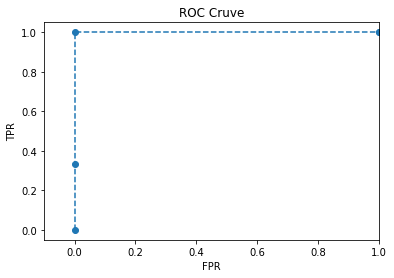

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Cruve')
plt.ylabel('TPR')

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced.

In [10]:
pr = summary.pr.toPandas()
pr

,recall,precision
0,0.000000,1.0
1,0.333333,1.0
2,1.000000,1.0
3,1.000000,0.6


Text(0, 0.5, 'precision')

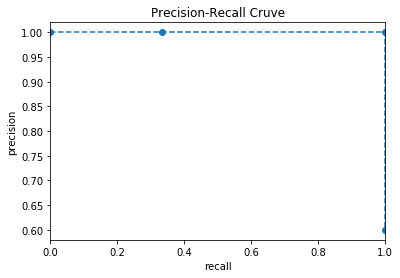

In [11]:
pr.plot(x='recall', y='precision', style='--o', legend=False)
plt.title('Precision-Recall Cruve')
plt.ylabel('precision')

The speed at which the model descends to the final result is shown in the objective history. We can access this through the objective history on the model summary:

In [12]:
summary.objectiveHistory

[0.6730116670092563,
 0.5042829330409727,
 0.36356862066874396,
 0.1252407018038337,
 0.08532556611276214,
 0.035504876415730455,
 0.018196494508571255,
 0.008817369922959136,
 0.004413673785392143,
 0.002194038351234709,
 0.0010965641148080857,
 0.000547657551985314,
 0.00027376237951490126,
 0.0001368465223657475,
 6.841809037070595e-05,
 3.420707791038497e-05,
 1.7103176664232043e-05,
 8.551470106426904e-06,
 4.275703677941461e-06,
 2.1378240117781303e-06,
 1.068856405465203e-06,
 5.34260020257524e-07,
 2.668135105897439e-07,
 1.3204627865316843e-07,
 6.768401481686428e-08,
 3.314547718487037e-08,
 1.6151438837494788e-08,
 8.309350118269286e-09]

## Decision Trees

Decision trees are one of the more friendly and interpretable models for performing classification because they’re similar to simple decision models that humans use quite often. For example, if you have to predict whether or not someone will eat ice cream when offered, a good feature might be whether or not that individual likes ice cream. In pseudocode, if person.likes(“ice_cream”), they will eat ice cream; otherwise, they won’t eat ice cream. A decision tree creates this type of structure with all the inputs and follows a set of branches when it comes time to make a prediction. This makes it a great starting point model because it’s easy to reason about, easy to inspect, and makes very few assumptions about the structure of the data. In short, rather than trying to train coeffiecients in order to model a function, it simply creates a big tree of decisions to follow at prediction time. This model also supports multiclass classification and provides outputs as predictions and probabilities in two different columns.


<img src="https://github.com/soltaniehha/Big-Data-Analytics-for-Business/blob/master/figs/11-01-Decision-Tree.png?raw=true" width="800" align="center"/>

*<div style="text-align: right"> From [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, et al </div>*

While this model is usually a great start, it does come at a cost. It can overfit data extremely quickly. By that we mean that, unrestrained, the decision tree will create a pathway from the start based on every single training example. That means it encodes all of the information in the training set in the model. This is bad because then the model won’t generalize to new data (you will see poor test set prediction performance). However, there are a number of ways to try and rein in the model by limiting its branching structure (e.g., limiting its height) to get good predictive power.

### Model Hyperparameters

There are many different ways to configure and train decision trees. Here are the hyperparameters that Spark’s implementation supports:

**`maxDepth`** (default: 5)

Since we’re training a tree, it can be helpful to specify a max depth in order to avoid overfitting to the dataset (in the extreme, every row ends up as its own leaf node). 

**`maxBins`** (default: 32)

In decision trees, continuous features are converted into categorical features and `maxBins` determines how many bins should be created from continous features. More bins gives a higher level of granularity. The value must be greater than or equal to 2 and greater than or equal to the number of categories in any categorical feature in your dataset. 

**`impurity`** (default: gini)

To build up a “tree” you need to configure when the model should branch. Impurity represents the metric (information gain) to determine whether or not the model should split at a particular leaf node. This parameter can be set to either be “entropy” or “gini” (default), two commonly used impurity metrics.

**`minInfoGain`** (default: 0.0)

This parameter determines the minimum information gain that can be used for a split. A higher value can prevent overfitting. This is largely something that needs to be determined from testing out different variations of the decision tree model.

**`minInstancesPerNode`** (default: 1)

Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.

### Training Parameters

These are configurations we specify in order to manipulate how we perform our training. Here is the training parameter for decision trees:

**`checkpointInterval`** 

Checkpointing is a way to save the model’s work over the course of training so that if nodes in the cluster crash for some reason, you don’t lose your work. A value of 10 means the model will get checkpointed every 10 iterations. Set this to -1 to turn off checkpointing. This parameter needs to be set together with a `checkpointDir` (a directory to checkpoint to) and with `useNodeIdCache=true`. Consult the Spark documentation for more information on checkpointing.

### Prediction Parameters

There is only one prediction parameter for decision trees: `thresholds`. Refer to the explanation for thresholds under “Logistic Regression”.

Here’s a minimal but complete example of using a decision tree classifier:

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier()
print(dt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree.

In [14]:
dtModel = dt.fit(bInput)

In [15]:
dtModel.transform(bInput).show()

+--------------+-----+-------------+-----------+----------+
|      features|label|rawPrediction|probability|prediction|
+--------------+-----+-------------+-----------+----------+
|[3.0,10.1,3.0]|  1.0|    [0.0,3.0]|  [0.0,1.0]|       1.0|
|[1.0,0.1,-1.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|[1.0,0.1,-1.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
| [2.0,1.1,1.0]|  1.0|    [0.0,3.0]|  [0.0,1.0]|       1.0|
| [2.0,1.1,1.0]|  1.0|    [0.0,3.0]|  [0.0,1.0]|       1.0|
+--------------+-----+-------------+-----------+----------+

